# House Price Prediction in a Specific City

This notebook implements a machine learning model to predict house prices in Sri Lanka. 

### Assignment Requirements Checklist:
- **Algorithm:** XGBoost (Not covered in standard intro lectures, more advanced than Linear Regression/Decision Trees).
- **Tooling:** SHAP for Explainability (XAI).
- **Process:** Data cleaning, encoding, train/test split, scaling, training, evaluation, and explanation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap
import joblib

sns.set_theme(style="whitegrid")

## 1. Data Loading and Exploration

In [ ]:
df = pd.read_csv('house_prices_srilanka.csv')

print("Head of the dataset:")
display(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nStatistics:")
display(df.describe())

Head of the dataset:


,district,area,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,has_garden,has_ac,water_supply,electricity,floors,year_built,price_lkr
0,Polonnaruwa,Polonnaruwa Central,14,5,4,112,2,False,False,Pipe-borne,Single phase,1,2022,16236332
1,Matale,Matale Central,26,7,5,250,2,True,False,Both,Single phase,3,1987,33907509
2,Mullaitivu,Mullaitivu Central,7,3,2,77,2,True,True,Well,Single phase,1,1988,5954312
3,Anuradhapura,New Town,2,2,2,39,1,True,True,Both,Three phase,2,2024,5177534
4,Batticaloa,Batticaloa Town,20,5,4,117,1,True,True,Well,Single phase,1,1995,20182409



Missing values:
district             0
area                 0
perch                0
bedrooms             0
bathrooms            0
kitchen_area_sqft    0
parking_spots        0
has_garden           0
has_ac               0
water_supply         0
electricity          0
floors               0
year_built           0
price_lkr            0
dtype: int64

Statistics:


,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,floors,year_built,price_lkr
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04
mean,11.510500,3.901600,3.171650,113.718800,1.141100,1.557150,2004.926550,1.598142e+07
std,8.519719,1.839426,1.530883,69.801873,0.939167,0.628135,11.817353,1.338156e+07
min,2.000000,1.000000,1.000000,35.000000,0.000000,1.000000,1985.000000,1.500000e+06
25%,5.000000,2.000000,2.000000,53.000000,0.000000,1.000000,1995.000000,6.591047e+06
50%,10.000000,4.000000,3.000000,95.000000,1.000000,1.000000,2005.000000,1.206384e+07
75%,16.000000,5.000000,5.000000,161.000000,2.000000,2.000000,2015.000000,2.096723e+07
max,80.000000,7.000000,5.000000,250.000000,3.000000,3.000000,2025.000000,1.500321e+08


## 2. Preprocessing

We need to encode categorical variables and scale numerical features.

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df.select_dtypes(exclude=['object', 'bool']).columns.tolist()
numerical_cols.remove('price_lkr')

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

X = df.drop('price_lkr', axis=1)
y = df['price_lkr']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Categorical columns: ['district', 'area', 'has_garden', 'has_ac', 'water_supply', 'electricity']
Numerical columns: ['perch', 'bedrooms', 'bathrooms', 'kitchen_area_sqft', 'parking_spots', 'floors', 'year_built']


/var/folders/xt/0yxzpfw93gz1bz87pt104jpc0000gn/T/ipykernel_51095/2730100957.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()


## 3. Train/Test Split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (16000, 13)
Test set shape: (4000, 13)


## 4. Model Training (XGBoost)

We use XGBoost, an efficient and popular gradient boosting implementation. It differs from traditional models like Linear Regression by building an ensemble of trees sequentially, optimization for speed and performance.

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


## 5. Explainability (XAI) using SHAP

SHAP (SHapley Additive exPlanations) helps us understand the contribution of each feature to the model's predictions.

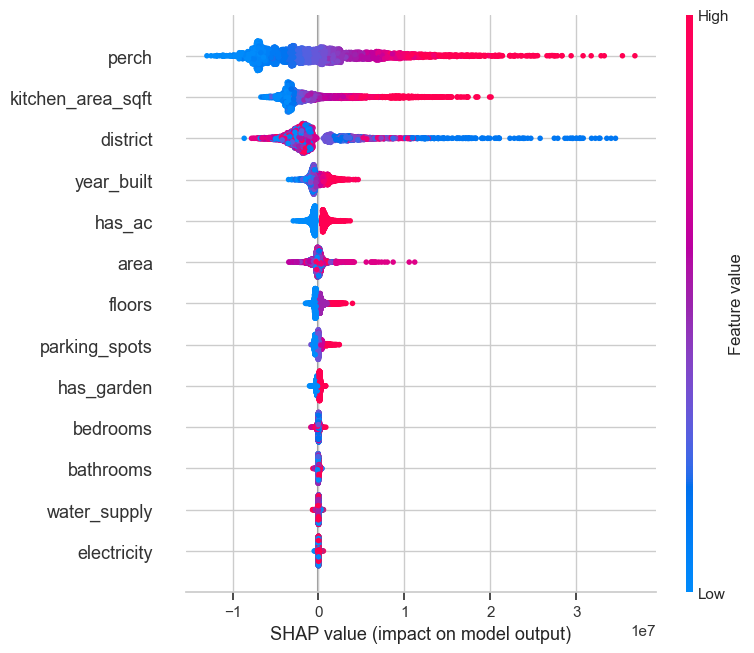

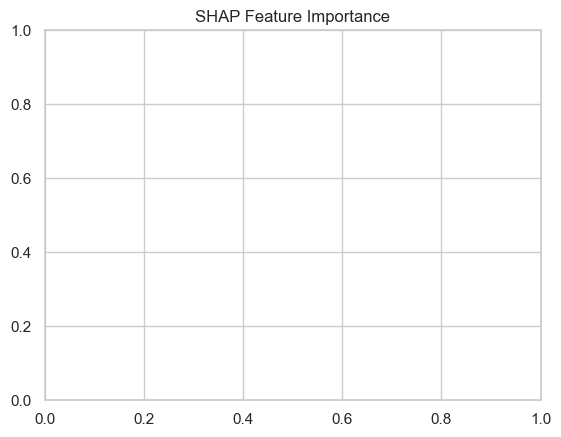

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Feature Importance")
plt.show()

## 6. Model Visualization (Native XGBoost)

Besides SHAP, we can "see" the model by looking at the feature weights and the actual decision trees.

Native Feature Importance Plot:


<Figure size 1000x800 with 0 Axes>

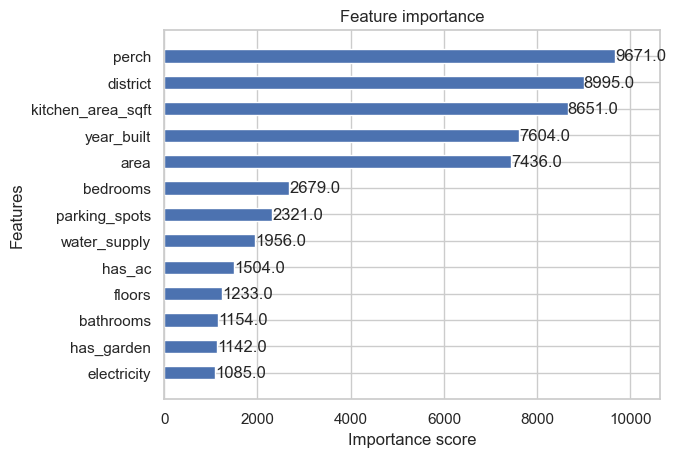


Decision Tree Visualization (First Tree):
Tree plotting skipped: Make sure graphviz is installed (brew install graphviz).


<Figure size 2000x1000 with 0 Axes>

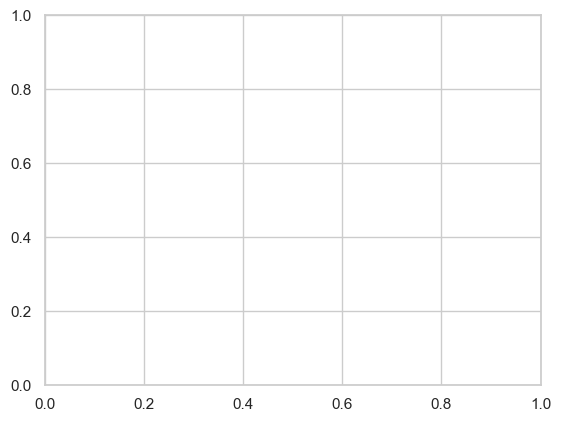

In [ ]:
print("Native Feature Importance Plot:")
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, height=0.5)
plt.show()

print("\nDecision Tree Visualization (First Tree):")
plt.figure(figsize=(20, 10))
try:
    xgb.plot_tree(model, num_trees=0)
    plt.show()
except Exception as e:
    print("Tree plotting skipped: Make sure graphviz is installed (brew install graphviz).")

## 7. Evaluation and Accuracy Prediction

Mean Squared Error: 6,392,024,924,160.00
Root Mean Squared Error: 2,528,245.42
Accuracy (R-squared Score): 0.9641


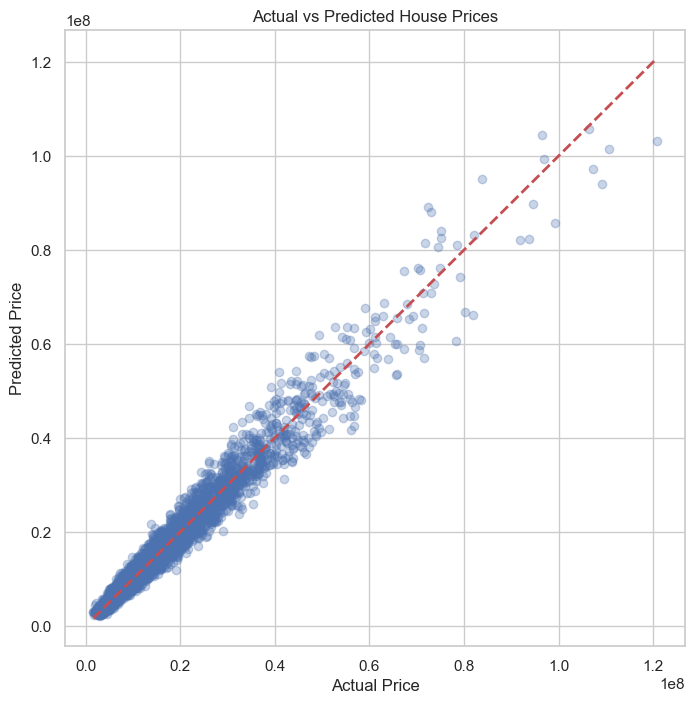

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:,.2f}")
print(f"Root Mean Squared Error: {rmse:,.2f}")
print(f"Accuracy (R-squared Score): {r2:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.show()

## 8. Saving the Model and Preprocessing Objects

To reuse the model for future predictions, we save the model, the scaler, and the encoders.

In [ ]:
model.save_model('house_price_model.json')

joblib.dump(scaler, 'scaler.joblib')

joblib.dump(le_dict, 'encoders.joblib')

print("Success! Saved files to folder:")
print("1. house_price_model.json (The Brain)")
print("2. scaler.joblib (Data Normalizer)")
print("3. encoders.joblib (Category Text-to-Number Maps)")

Success! Saved files to folder:
1. house_price_model.json (The Brain)
2. scaler.joblib (Data Normalizer)
3. encoders.joblib (Category Text-to-Number Maps)
